In [1]:
import os
import numpy
import pandas
import xarray
import netCDF4 as nc
import cartopy.crs
import cmocean
import rioxarray
from array import *
from cmocean import cm as cmo
from glob import glob
from cartopy import crs,feature
import matplotlib as mpl
from matplotlib import pyplot as plt, patches, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
# used to make subplot labels consistent between figures
from matplotlib.offsetbox import AnchoredText
#from salishsea_tools import geo_tools, tidetools

In [4]:
graphics_dir = Path('/ocean/rmueller/MIDOSS/graphics/')
geotiff_directory = Path('/data/MIDOSS/geotiffs')
# larger, presentation-size graphics require different xy text specifications
graphics_size='large'
if graphics_size=='large':
    # graphics style
    plt.style.use(r"../style_templates/MuellerEtAl_matplotlibrc.template")
    #plt.style.use(r"../../style_templates/general_matplotlibrc.template")

# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
# linewidth for coast/rivers
lw=0.3
# reducd dpi to make smaller graphics
custom_dpi=600

In [5]:
mask = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = xarray.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
spills = pandas.read_csv('/data/sallen/results/MIDOSS/Monte_Carlo/northern_strait.csv')

# Load ETOPO1 data set
topo = xarray.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ETOPO1_Bed_g_gmt4.grd')

# Crop to Salish Sea
extent = [-126.5, -121.2, 46.8, 51.2]
topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
#lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]
tmask = mask.tmask[0, 0, ...].values

In [6]:
spills_dir_name = 'spill_files_091921'
# On Salish
data_directory = Path(f'/ocean/rmueller/MIDOSS/{spills_dir_name}')
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/MEOPAR_ASM_2022')
# Load Oil Attribution file 
oil_attribution_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
# create list of spill files to plot/evaluate
filenames = sorted(glob(os.path.join(data_directory,"*.csv")))

our_spills = '/data/sallen/results/MIDOSS/'+\
'SalishSea_oil_spills_corrected_24mar2022_indomain_fixedcol_fixedwrap.csv'


# load spills files

In [8]:
fnames = [
    'Lagrangian_akns.dat',
    'Lagrangian_bunker.dat',
    'Lagrangian_dilbit.dat',
    'Lagrangian_diesel.dat',
    'Lagrangian_gas.dat',
    'Lagrangian_jet.dat',
    'Lagrangian_other.dat'
]
MIDOSSlabels=[
    'ANS',
    'Bunker-C',
    'Dilbit',
    'Diesel',
    'Diesel',
    'Diesel',
    'Bunker-C'
]

In [9]:
df={}
for index,fn in enumerate(filenames):    
    if index==3:
        print(index,our_spills)
        df[index] = pandas.read_csv(our_spills)
    else:
        print(index,fn)
        df[index] = pandas.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
         fnames, MIDOSSlabels
    )
    if index == 0:
        df_combined = df[index].copy()
        
    else:
        df_combined = pandas.concat([df_combined, df[index]])
    

0 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_1.csv
1 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_2.csv
2 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_3.csv
3 /data/sallen/results/MIDOSS/SalishSea_oil_spills_corrected_24mar2022_indomain_fixedcol_fixedwrap.csv
4 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_5.csv
5 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_6.csv
6 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_7.csv
7 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_8.csv
8 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_9.csv


# plot number and volume of spills for this study

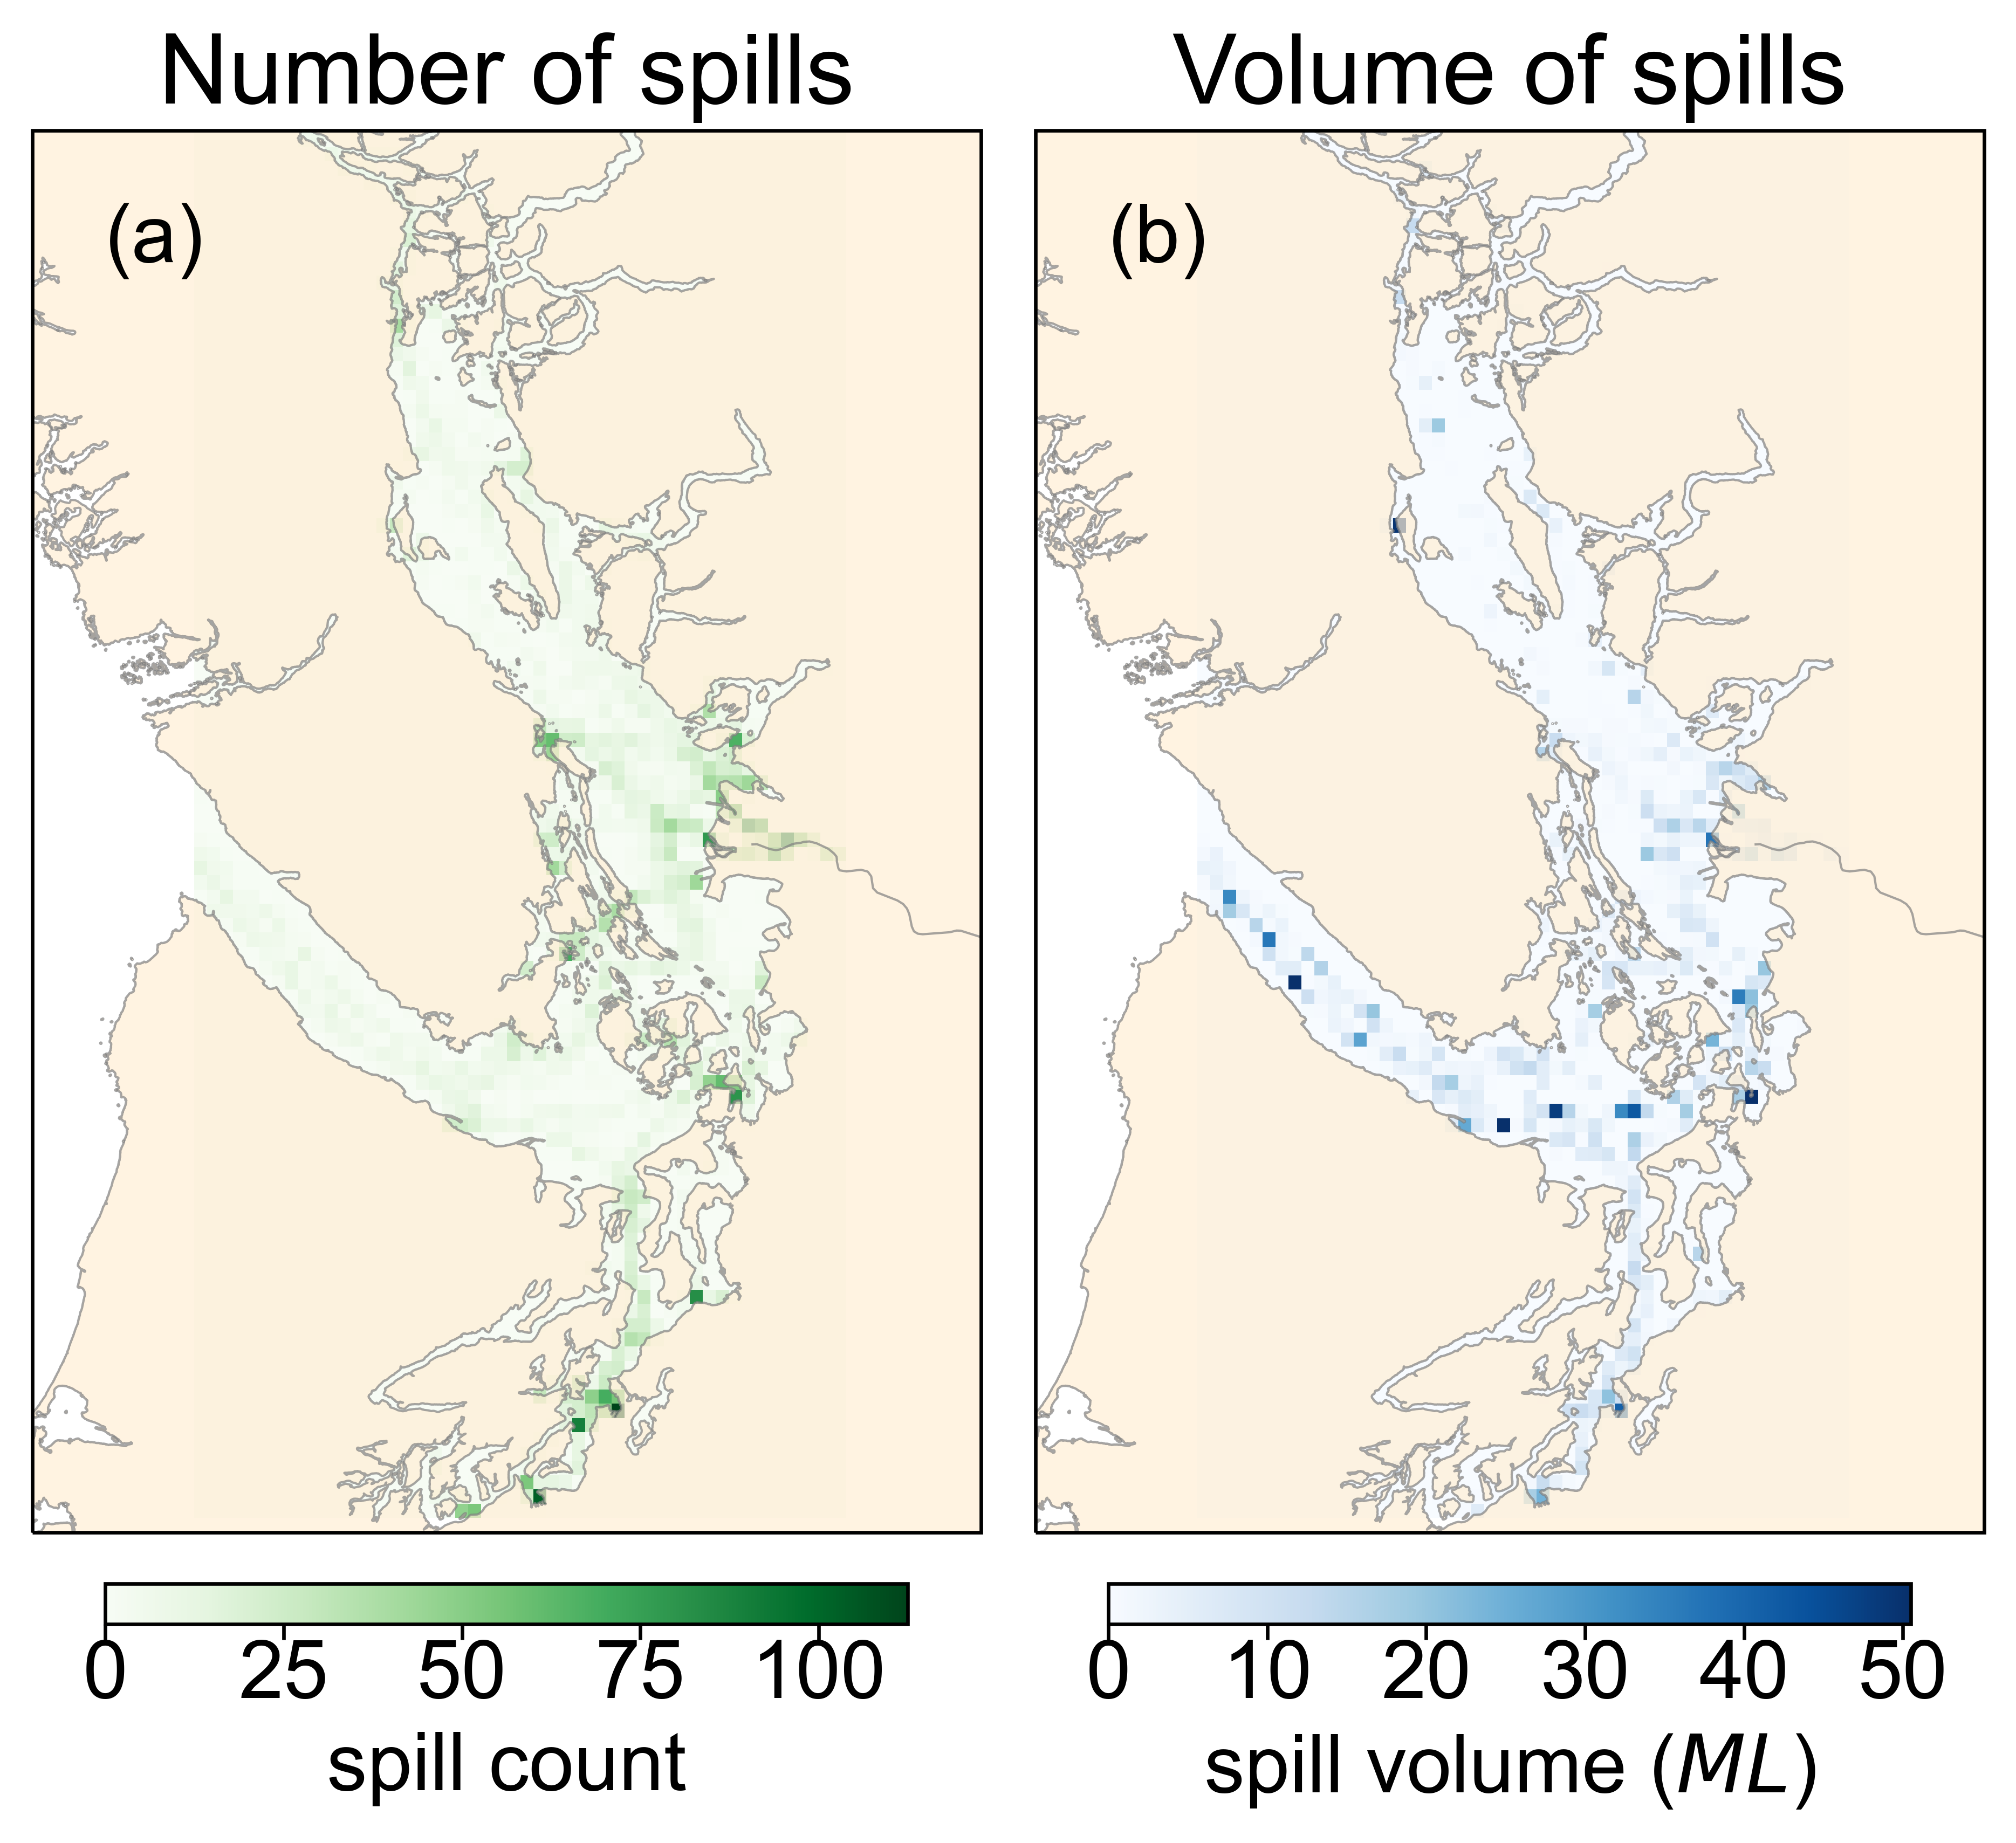

In [10]:
#linewidth for land mask
lw=0.5

# color of shoreline
ec='grey'
nbins_x=50
nbins_y=100

fig, axs = plt.subplots(1, 2, 
    figsize=(8, 7), #(width, height)
    dpi=custom_dpi, 
    subplot_kw={'projection': rotated_crs, 
        "facecolor": "white"},
    gridspec_kw={
       'width_ratios': [1,1],
       'height_ratios': [1],
       'wspace': 0,
       'hspace': 0}
)
for ax in axs:
    ax.add_feature(feature.GSHHSFeature(
        'full', edgecolor=ec, linewidth=lw, facecolor='papayawhip',
         zorder=1, alpha=0.7
    ))
    ax.add_feature(feature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines',
        scale='10m',  edgecolor=ec, linewidth=lw, facecolor='none',
        zorder=1, alpha=0.7
    ))
    ax.set_extent([-124, -123.75, lat.min()-0.15, lat.max()])
    ax.set_aspect(1)

# do coordinate conversion of (x,y)
xynps = axs[0].projection.transform_points(
    crs.Geodetic(), 
    numpy.array(df[3].spill_lon), 
    numpy.array(df[3].spill_lat))

# ~~~ Number of spills ~~~
# calculate histograms for number of spills and plot using pcolormesh
r3_count,xe,ye = numpy.histogram2d(
    xynps[:,0], 
    xynps[:,1],
    bins=(nbins_x,nbins_y)
);

Yr3,Xr3 = numpy.meshgrid(ye,xe)

# ~~~ Number of spills ~~~
# calculate histograms for number of spills and plot using pcolormesh
r3_count,xe,ye = numpy.histogram2d(
    xynps[:,0], 
    xynps[:,1],
    bins=(nbins_x,nbins_y)
);

# ~~~ Volume of spills ~~~

# calculate histograms for number of spills and plot using pcolormesh
r3_vol,xe,ye = numpy.histogram2d(
    xynps[:,0], 
    xynps[:,1], 
    weights = df[3].spill_volume,
    bins=(nbins_x,nbins_y)
); 

C_count=axs[0].pcolormesh(Xr3, Yr3, r3_count, 
    cmap='Greens',
    vmin=0,
    vmax=0.5*r3_count.max(),
    zorder=0)
C_vol=axs[1].pcolormesh(Xr3, Yr3, r3_vol, 
    cmap='Blues',
    vmin=0,
    vmax=0.5*r3_vol.max(),
    zorder=0)

axs[0].set_title('Number of spills');
axs[1].set_title('Volume of spills');

# Use anchored text to make location of subplot labels consistent between figures
a_anchored = AnchoredText("(a)", loc=2,frameon=False)
b_anchored = AnchoredText("(b)", loc=2,frameon=False)
axs[0].add_artist(a_anchored)
axs[1].add_artist(b_anchored)

# Add colorbars
cbar0=fig.colorbar(C_count, 
    ax=axs[0], 
    pad=0.03, shrink=0.8,
    location='bottom', 
    label='spill count',
    ticks=[0,25,50,75,100])
cbar1=fig.colorbar(C_vol, 
    ax=axs[1],  
    pad=0.03, shrink=0.8,
    location='bottom',
    label='spill volume ($ML$)',
    ticks=[0,1e7,2e7,3e7,4e7,5e7,6e7])
cbar0.ax.set_xticklabels([0,25,50,75,100])
cbar1.ax.set_xticklabels([0,10,20,30,40,50,60])

if custom_dpi>=600:
    plt.savefig(graphics_dir/'SpillCount_SpillVolume.png')
else:
    plt.savefig(graphics_dir/'SpillCount_SpillVolume_small.png')

# Number of spills by oil type

In [23]:
oil_types = df[3]['Lagrangian_template'].explode().unique().tolist()

In [28]:
df_oils = {}
for oil_type in oil_types:
    df_oils[oil_type]=df[3][df[3]['Lagrangian_template']==oil_type]

In [25]:
oil_type

'Bunker-C'